In [1]:
import os
import numpy as np   
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import json

# Bild- und Maskenpfade laden
image_dir = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Trainingsset/Testbilder2/'
mask_dir = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Trainingsset/Testmasken2/'

image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])

# Funktionen zum Laden und Vorverarbeiten
def load_and_preprocess_image_pillow(img_path):
    img = Image.open(img_path)
    img = img.resize((256, 192))
    img = np.array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=-1)
    return img

def load_and_preprocess_mask_pillow(mask_path):
    mask = Image.open(mask_path)
    mask = mask.resize((256, 192))
    mask = np.array(mask)
    mask = np.where(mask > 128, 1, 0)
    mask = np.expand_dims(mask, axis=-1)
    return mask

# Daten laden
X = np.array([load_and_preprocess_image_pillow(path) for path in image_paths])
Y = np.array([load_and_preprocess_mask_pillow(path) for path in mask_paths])

# Dice Metric
def dice_metric(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

# Benutzerdefinierte Verlustfunktion
def combined_loss(y_true, y_pred, smooth=1e-6, binary_weight=0.5, dice_weight=0.5):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    dice_loss = 1 - (2. * intersection + smooth) / (union + smooth)
    return binary_weight * bce + dice_weight * dice_loss

# U-Net Modell
def unet_model(input_size=(192, 256, 1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(0.3)(pool1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(0.4)(pool2)

    conv4 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4 = Dropout(0.4)(pool4)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    bottleneck = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    bottleneck = BatchNormalization()(bottleneck)

    up6 = UpSampling2D(size=(2, 2))(bottleneck)
    up6 = Conv2D(256, 2, activation='relu', padding='same')(up6)
    up6 = BatchNormalization()(up6)
    merge6 = concatenate([conv3, up6], axis=3)

    conv6 = Conv2D(256, 3, activation='relu', padding='same')(merge6)
    conv6 = BatchNormalization()(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = Conv2D(128, 2, activation='relu', padding='same')(up7)
    up7 = BatchNormalization()(up7)
    merge7 = concatenate([conv2, up7], axis=3)

    conv7 = Conv2D(128, 3, activation='relu', padding='same')(merge7)
    conv7 = BatchNormalization()(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = Conv2D(64, 2, activation='relu', padding='same')(up8)
    up8 = BatchNormalization()(up8)
    merge8 = concatenate([conv1, up8], axis=3)

    conv8 = Conv2D(64, 3, activation='relu', padding='same')(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)

    conv8 = Conv2D(1, 1, activation='sigmoid')(conv8)

    model = Model(inputs=inputs, outputs=conv8)
    return model

# Trainings-Konfiguration
model = unet_model()
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss=lambda y_true, y_pred: combined_loss(y_true, y_pred, binary_weight=0.5, dice_weight=0.5), metrics=[dice_metric])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
best_model_path = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/spheroid_segmentation_unet_trained4.h5'

# Training
history = model.fit(X, Y, batch_size=8, epochs=1000, validation_split=0.2, callbacks=[early_stopping, reduce_lr], verbose=1)

# Speichern des besten Modells und Trainingshistorie
model.save(best_model_path)
history_file = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/training_history.json_spheroid_segmentation_unet_trained4'
with open(history_file, 'w') as f:
    json.dump(history.history, f)

print(f"Bestes Modell wurde unter {best_model_path} gespeichert.")
print(f"Training Historie wurde unter {history_file} gespeichert.")


Epoch 1/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 847s 7s/step - dice_metric: 0.4550 - loss: 0.5051 - val_dice_metric: 0.1398 - val_loss: 0.6367 - learning_rate: 1.0000e-04
Epoch 2/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 829s 6s/step - dice_metric: 0.6433 - loss: 0.2971 - val_dice_metric: 0.0680 - val_loss: 0.6922 - learning_rate: 1.0000e-04
Epoch 3/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 794s 6s/step - dice_metric: 0.7179 - loss: 0.2269 - val_dice_metric: 0.0295 - val_loss: 0.7693 - learning_rate: 1.0000e-04
Epoch 4/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 756s 6s/step - dice_metric: 0.7954 - loss: 0.1664 - val_dice_metric: 0.3107 - val_loss: 0.5797 - learning_rate: 1.0000e-04
Epoch 5/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 755s 6s/step - dice_metric: 0.8171 - loss: 0.1554 - val_dice_metric: 0.6787 - val_loss: 0.4080 - learning_rate: 1.0000e-04
Epoch 6/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 755s 6s/step - dice_metric: 0.8827 - loss: 0.0977 - val_dice_metric: 0.7250 - val_loss: 0.4488 - learning_rate: 1.0000e-04
Epoch 7/10

Bestes Modell wurde unter C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/spheroid_segmentation_unet_trained4.h5 gespeichert.
Training Historie wurde unter C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/training_history.json_spheroid_segmentation_unet_trained4 gespeichert.


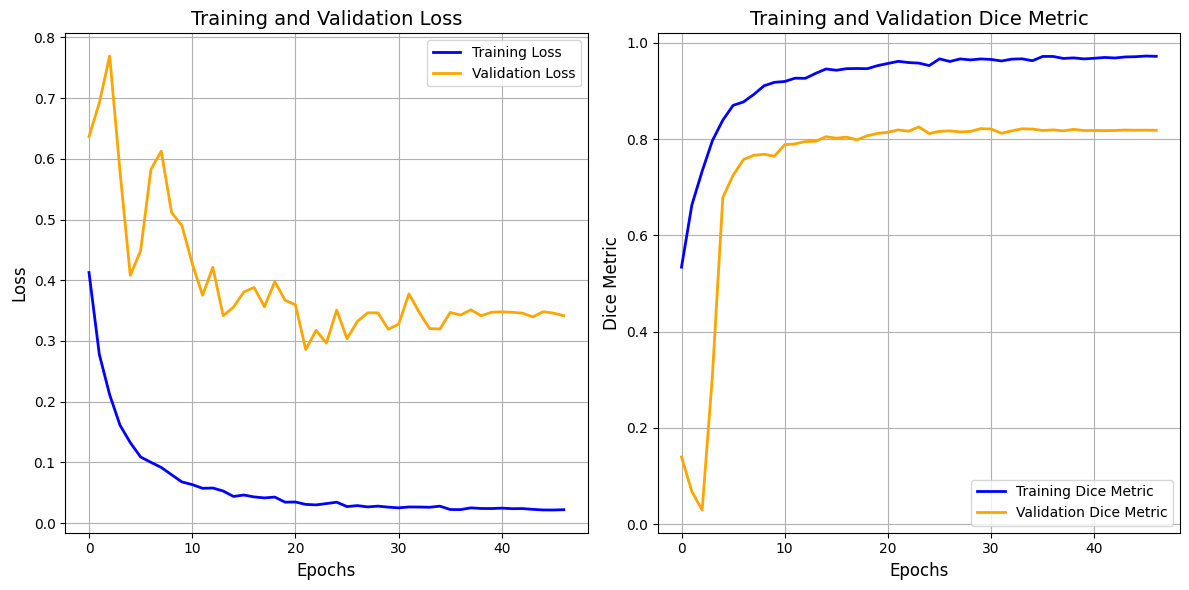

In [2]:
import json
import matplotlib.pyplot as plt

# Lade den Trainingsverlauf aus der JSON-Datei
history_file = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/training_history.json_spheroid_segmentation_unet_trained4'

# Öffnen und Laden der JSON-Datei
with open(history_file, 'r') as Trainingsverlauf:
    history = json.load(Trainingsverlauf)

# Plotten
plt.figure(figsize=(12, 6))  # Breite und Höhe des gesamten Plots

# Verlust (Loss)
plt.subplot(1, 2, 1)  # 1 Zeile, 2 Spalten, 1. Plot
plt.plot(history['loss'], label='Training Loss', color='blue', linewidth=2)
plt.plot(history['val_loss'], label='Validation Loss', color='orange', linewidth=2)
plt.title('Training and Validation Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)

# Dice Metric
plt.subplot(1, 2, 2)  # 1 Zeile, 2 Spalten, 2. Plot
plt.plot(history['dice_metric'], label='Training Dice Metric', color='blue', linewidth=2)
plt.plot(history['val_dice_metric'], label='Validation Dice Metric', color='orange', linewidth=2)
plt.title('Training and Validation Dice Metric', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Dice Metric', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)

# Abstände zwischen den Subplots anpassen
plt.tight_layout()

# Plot anzeigen und speichern
plt.savefig('C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/training_history_spheroid_segmentation_unet_trained3.1.png')
plt.show()
